In [5]:
from hydra import compose, initialize
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

with initialize(version_base=None, config_path="../configs/filepaths"):
    filepaths = compose(config_name="filepaths")

In [6]:
rule_id = "decarb"
mc = pd.read_csv(
    Path(filepaths.interim_data) / rule_id / "mech_coverage.csv",
)
ss = pd.read_csv(
    Path(filepaths.interim_data) / rule_id / "summary_stats.csv",
)
mc.head()

,scl_lb,mech_id,inf_id,coverage,atom_ratio
0,1,0,0,0.750000,2.500000
1,1,1,0,0.666667,3.333333
2,1,2,0,0.500000,2.500000
3,1,3,0,0.250000,2.500000
4,1,4,0,0.400000,2.000000


In [7]:
ss.head(15)

,scl_lb,n_novel_subgraphs,n_total_inferred,rxn_cov_frac
0,1,24,83,0.965116
1,5,19,59,0.779070
2,7,11,47,0.697674
3,10,10,33,0.697674
4,12,4,25,0.558140
5,15,2,7,0.383721
6,20,1,3,0.383721
7,25,1,3,0.383721
8,30,2,2,0.383721
9,35,0,0,0.000000


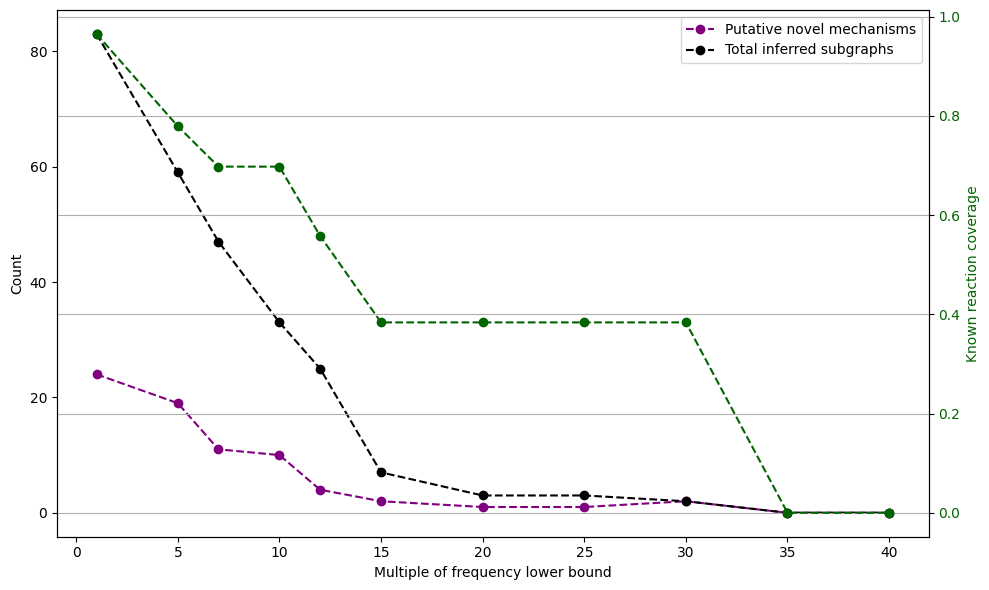

In [32]:
ax2_color = 'darkgreen'
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(ss["scl_lb"], ss["n_novel_subgraphs"], color='purple', ls='--', marker='o', label="Putative novel mechanisms")
ax1.plot(ss["scl_lb"], ss["n_total_inferred"], color='black', ls='--', marker='o', label="Total inferred subgraphs")
ax1.set_xlabel("Multiple of frequency lower bound")
ax1.set_ylabel("Count")

ax2 = ax1.twinx()
ax2.plot(
    ss['scl_lb'], 
    ss['rxn_cov_frac'],
    'o--', 
    label='Known reaction coverage', 
    color=ax2_color
)
ax2.set_ylabel('Known reaction coverage', color=ax2_color)
ax2.tick_params(axis='y', labelcolor=ax2_color)

fig.tight_layout()
ax1.legend()
plt.grid()
plt.show()

In [29]:
frac_mech_cov = mc.groupby(["scl_lb", "mech_id"]).agg(
    max_coverage=("coverage", "max")
).groupby("scl_lb").agg(
    frac_mech_covered=("max_coverage", lambda x: np.sum(x == 1) / len(x))
)
frac_mech_cov.reset_index(inplace=True)
frac_mech_cov

,scl_lb,frac_mech_covered
0,1,0.551724
1,5,0.310345
2,7,0.310345
3,10,0.241379
4,12,0.241379
5,15,0.103448
6,20,0.103448
7,25,0.103448
8,30,0.000000


In [30]:
extra_atoms = mc[mc["coverage"] == 1].groupby("scl_lb").agg(
    mean_atom_ratio=("atom_ratio", "mean"),
    stddev_atom_ratio=("atom_ratio", "std")
)
extra_atoms.reset_index(inplace=True)
extra_atoms

,scl_lb,mean_atom_ratio,stddev_atom_ratio
0,1,2.915706,1.355835
1,5,2.068922,0.404040
2,7,1.940083,0.299348
3,10,1.852564,0.283290
4,12,1.795139,0.269736
5,15,1.550000,0.193649
6,20,1.375000,0.136931
7,25,1.375000,0.136931


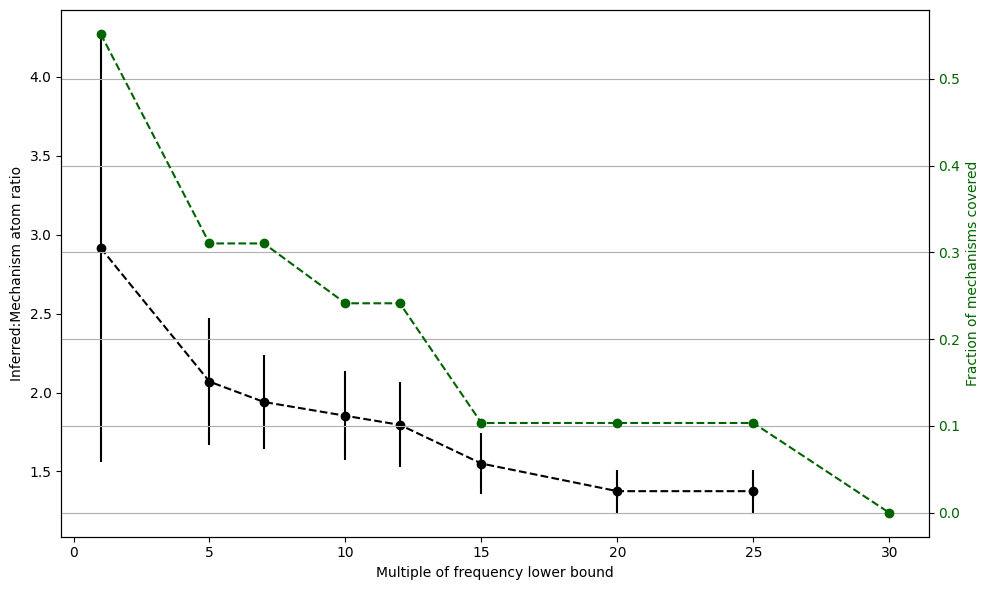

In [31]:

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot max_coverage with error bars
ax1.errorbar(
    x=extra_atoms['scl_lb'],
    y=extra_atoms['mean_atom_ratio'],
    yerr=extra_atoms['stddev_atom_ratio'],
    fmt='o--', 
    label='Inferred:Mechanism atom ratio', 
    color='black'
)
ax1.set_xlabel('Multiple of frequency lower bound')
ax1.set_ylabel('Inferred:Mechanism atom ratio', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis for mean_extra_atoms
ax2 = ax1.twinx()
ax2.plot(
    frac_mech_cov['scl_lb'], 
    frac_mech_cov['frac_mech_covered'],
    'o--', 
    label='Fraction of mechanisms covered', 
    color='darkgreen'
)
ax2.set_ylabel('Fraction of mechanisms covered', color='darkgreen')
ax2.tick_params(axis='y', labelcolor='darkgreen')

# Adding grid and title
fig.tight_layout()
plt.grid(True)
plt.show()